#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта:**

Постройте модель для предсказания количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных:**

`/datasets/taxi.csv`

Целевой признак:
- `num_orders` - от англ. *number of orders*, «число заказов».



In [1]:
# импорт библиотек

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima_model import ARMA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [2]:
# отключу предупреждения
import warnings
warnings.filterwarnings('ignore')

## Подготовка

### Обзор данных

In [4]:
#прочитаю датасет и ознакомлюсь с данными
try:
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
data.sort_index(inplace=True)

In [5]:
# получаю общую сводку
data.info()

# проверю на корректный вывод
display(data.sample(5))

# проверяю имена колонок на пробелы
display(data.columns)

# сводка по численным данным
data.describe().T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-07-05 12:30:00,10
2018-03-04 20:20:00,13
2018-04-28 02:20:00,21
2018-05-11 14:20:00,10
2018-03-08 18:00:00,8


Index(['num_orders'], dtype='object')

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Проверка на явные дубликаты, построение и проверка матрицы корреляции не требуются.  
Визуализирую количество заказов до и после ресэмплинга.

<AxesSubplot:xlabel='num_orders', ylabel='Count'>

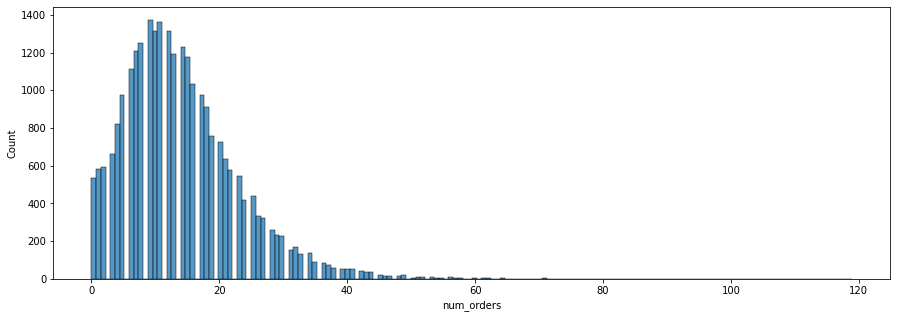

In [6]:
plt.figure(figsize=(15, 5))

sns.histplot(data['num_orders'])

<AxesSubplot:xlabel='num_orders'>

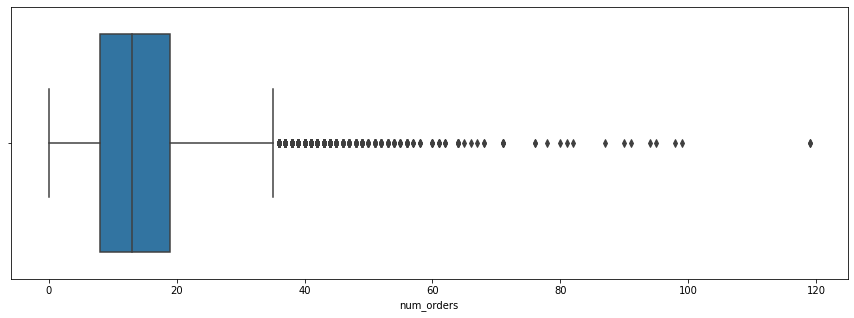

In [7]:
plt.figure(figsize=(15, 5))

sns.boxplot(data['num_orders'])

In [8]:
# по заданию работаем с интервалами в один час

data_1h = data.resample('1H').sum()

data_1h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='num_orders', ylabel='Count'>

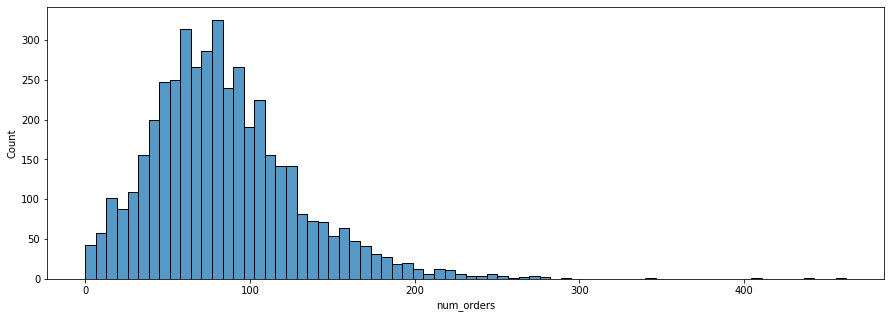

In [9]:
plt.figure(figsize=(15, 5))

sns.histplot(data_1h['num_orders'])

<AxesSubplot:xlabel='num_orders'>

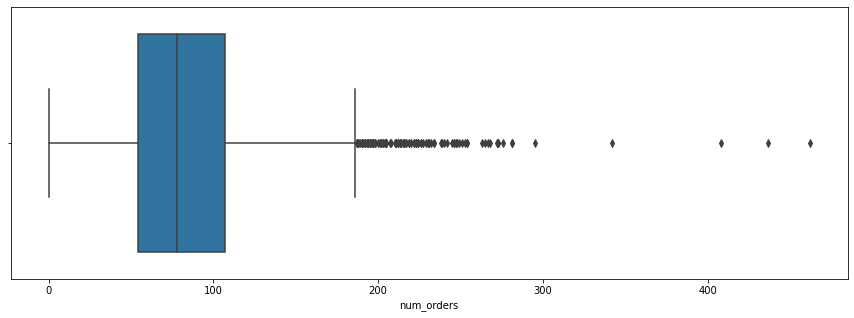

In [10]:
plt.figure(figsize=(15, 5))

sns.boxplot(data_1h['num_orders'])

Похоже на аномальные значения. Но так как работа ведется с временными рядами то в наличии этих знаений могут быть закономерности. Не буду отбрасывать аномальные значения и перейду к анализу.

In [11]:
data_1h.query('num_orders > 190').count()

num_orders    108
dtype: int64

## Анализ

### Визуализация данных

Визуализирую распределенные всех данных по времени.

<AxesSubplot:xlabel='datetime'>

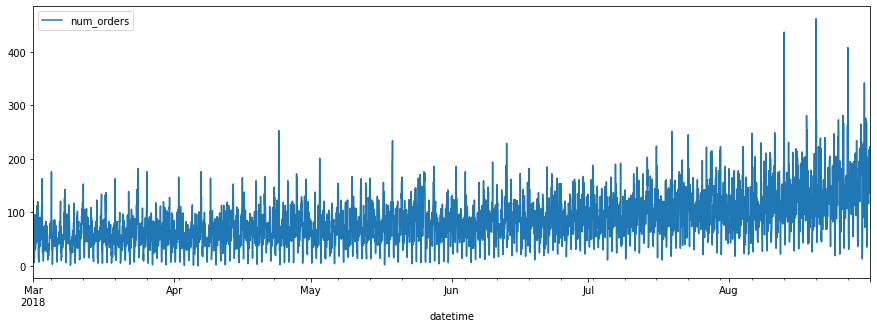

In [12]:
data_1h.plot(figsize=(15, 5))

Видимый плавный рост от марта к августу. Взгляну на данные за выходной день, будний день, неделю и месяц. В качестве дней недели выберу первое июля(воскресенье) и 9 июля(понедельник), в качестве недели середину июня, в качестве месяца выберу июнь.

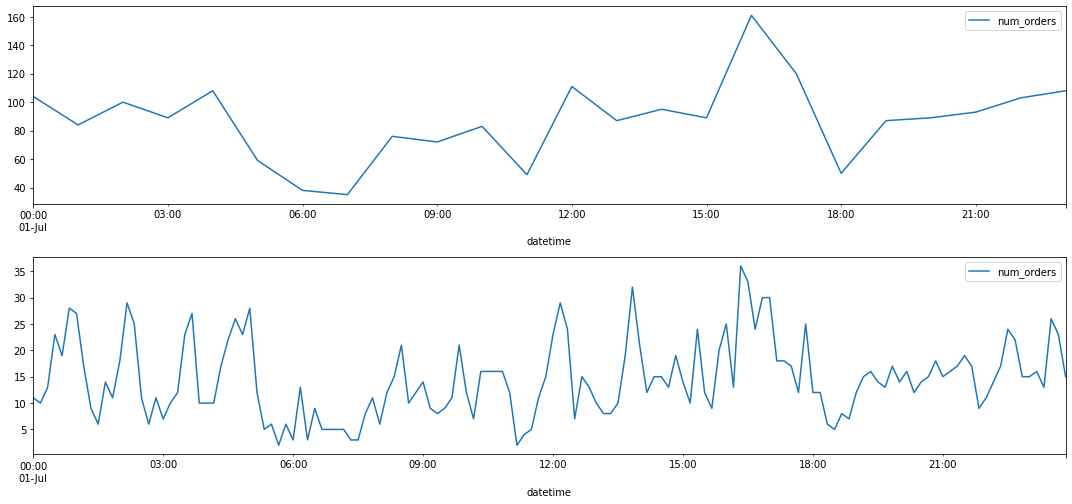

In [13]:
plt.subplot(311)
data_1h['2018-07-01'].plot(figsize=(15, 10), ax=plt.gca())
plt.subplot(312)
data['2018-07-01'].plot(figsize=(15, 10), ax=plt.gca())
plt.tight_layout()

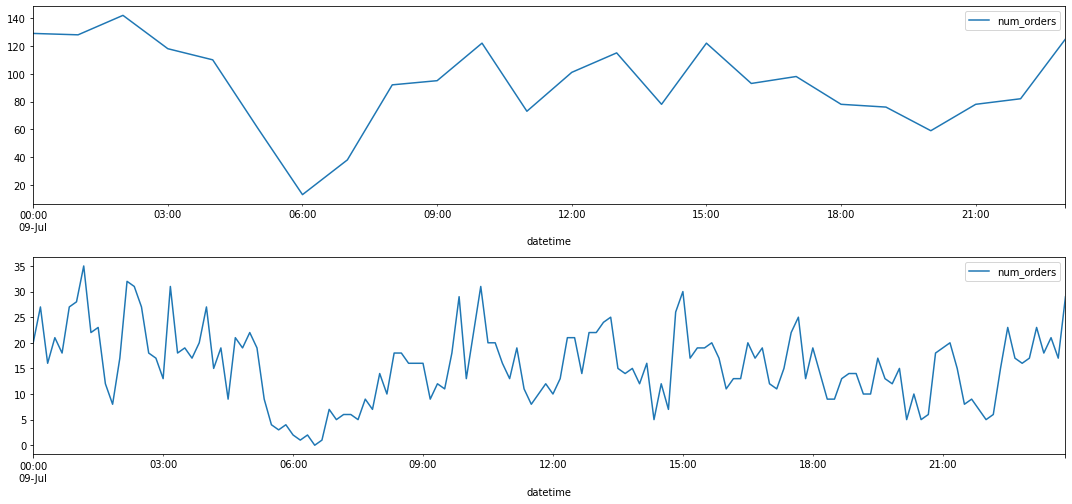

In [14]:
plt.subplot(311)
data_1h['2018-07-09'].plot(figsize=(15, 10), ax=plt.gca())
plt.subplot(312)
data['2018-07-09'].plot(figsize=(15, 10), ax=plt.gca())
plt.tight_layout()

Максимальный спад активности в районе шести часов утра.

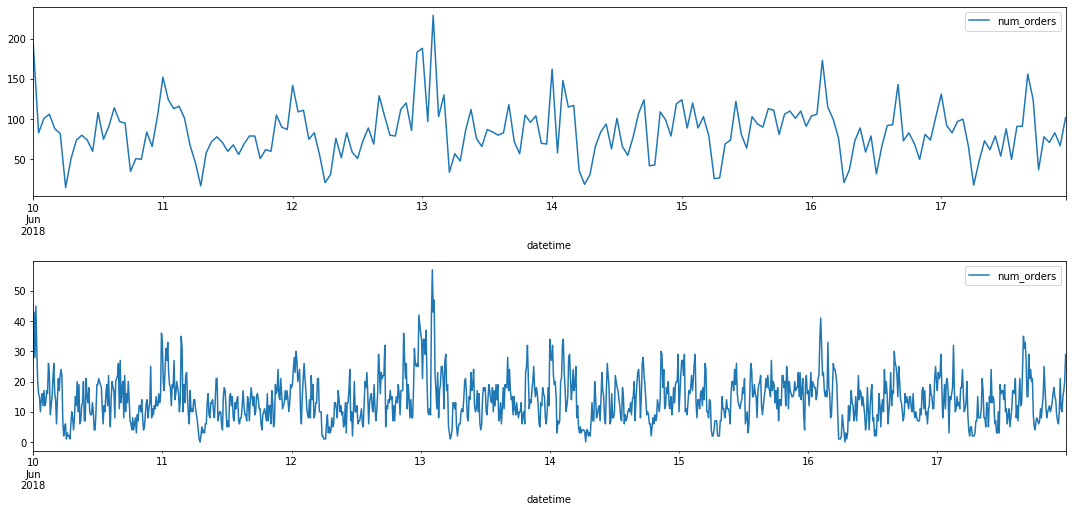

In [15]:
plt.subplot(311)
data_1h['2018-06-10':'2018-06-17'].plot(figsize=(15, 10), ax=plt.gca())
plt.subplot(312)
data['2018-06-10':'2018-06-17'].plot(figsize=(15, 10), ax=plt.gca())
plt.tight_layout()

В неделе четко послеживается динамика каждого дня.

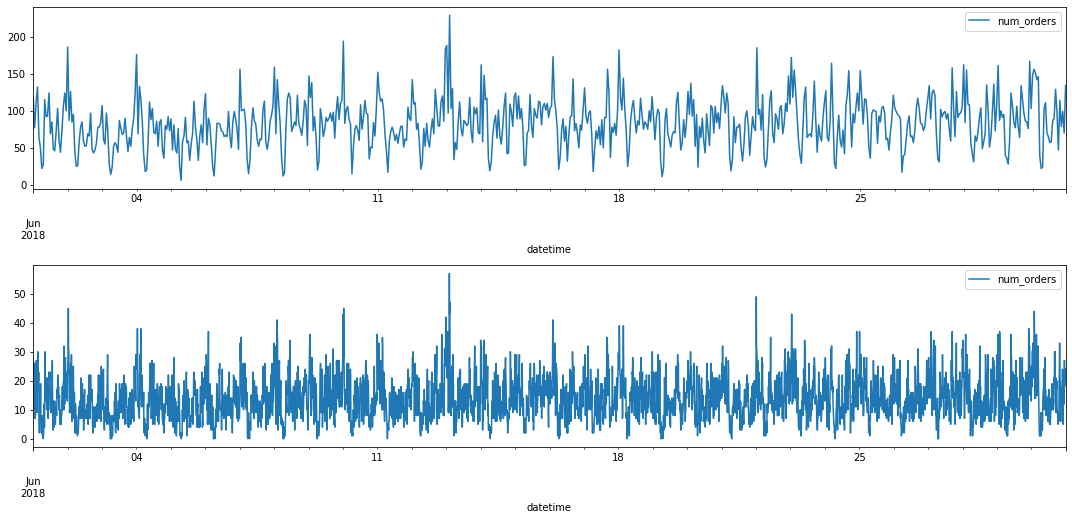

In [16]:
plt.subplot(311)
data_1h['2018-06'].plot(figsize=(15, 10), ax=plt.gca())
plt.subplot(312)
data['2018-06'].plot(figsize=(15, 10), ax=plt.gca())
plt.tight_layout()

Пульс определенно есть...

Разложу временной ряд на тренд и сезонную компоненту.

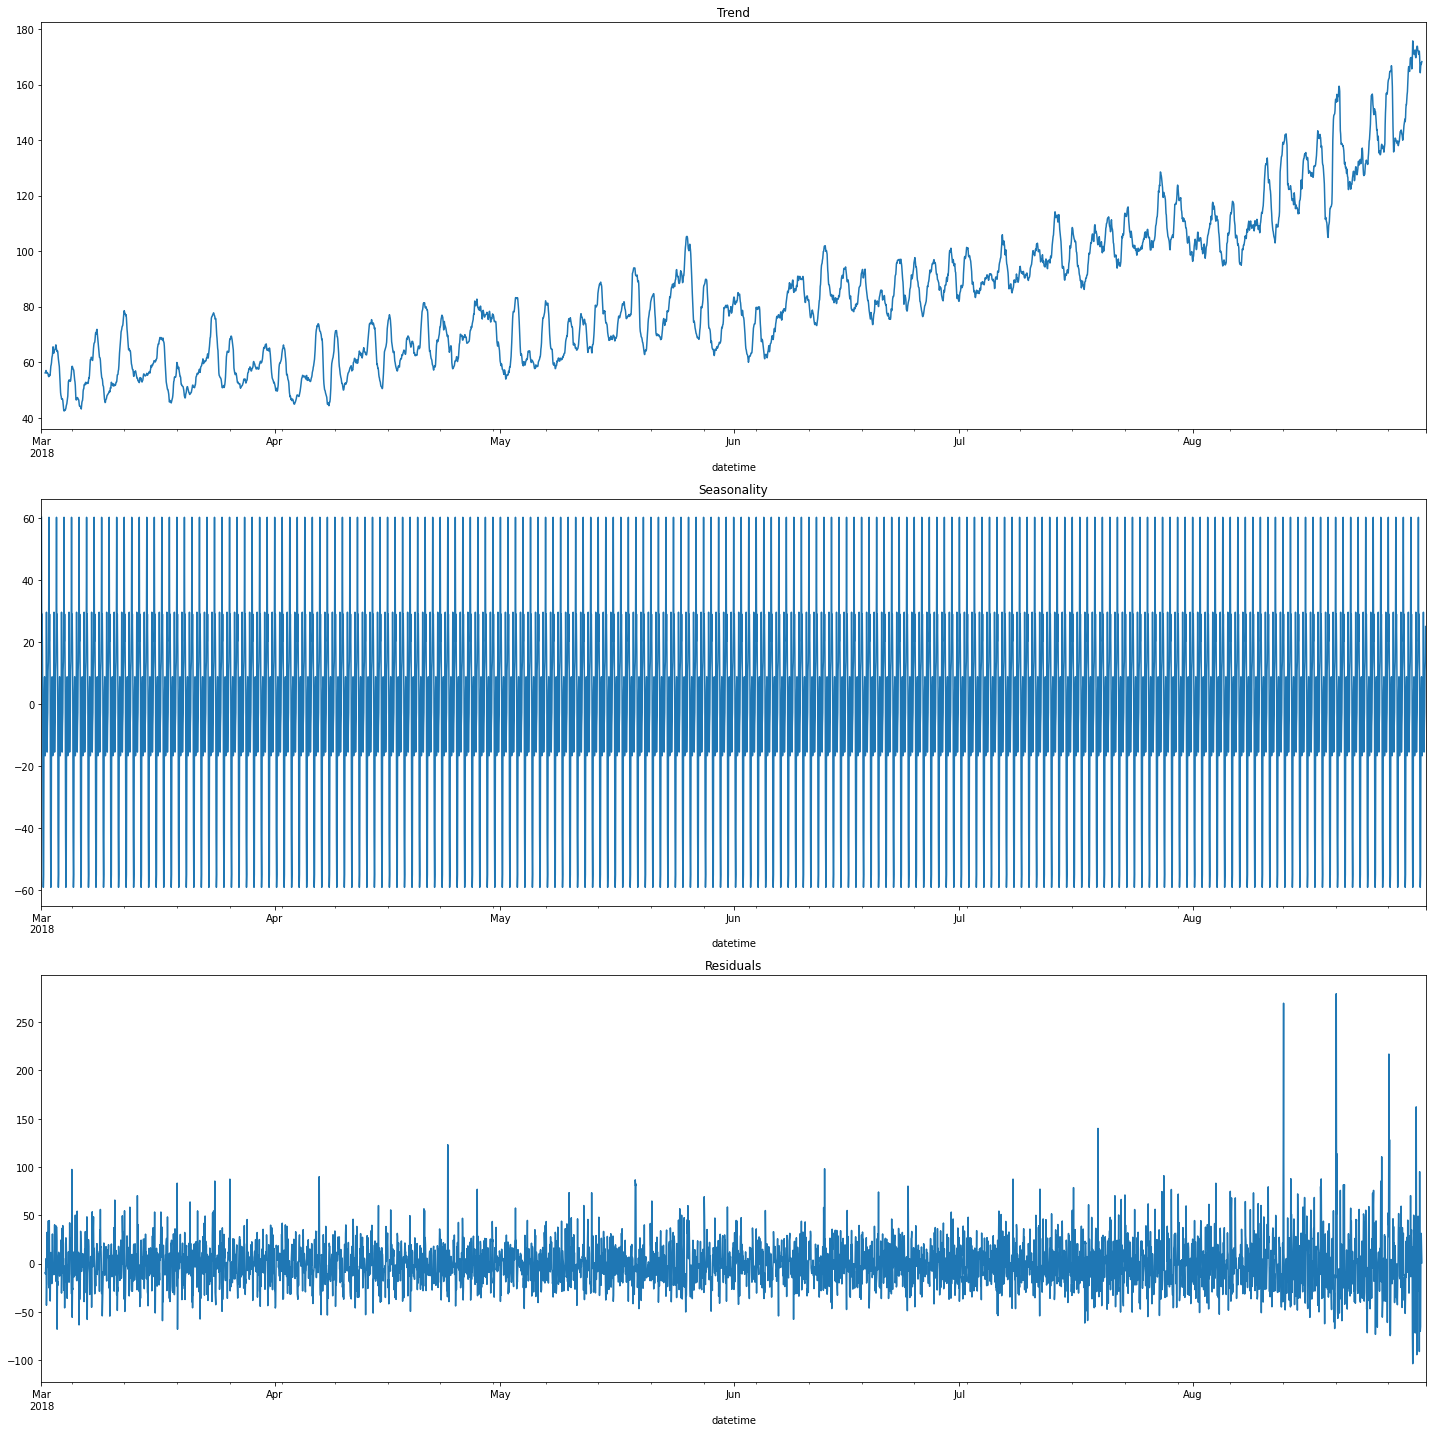

In [17]:
decomposed_data = seasonal_decompose(data_1h)

plt.figure(figsize=(20, 20))

plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Явный тренд на увеличение количества заказов.

Проверю данные за выбранную неделю и месяц.

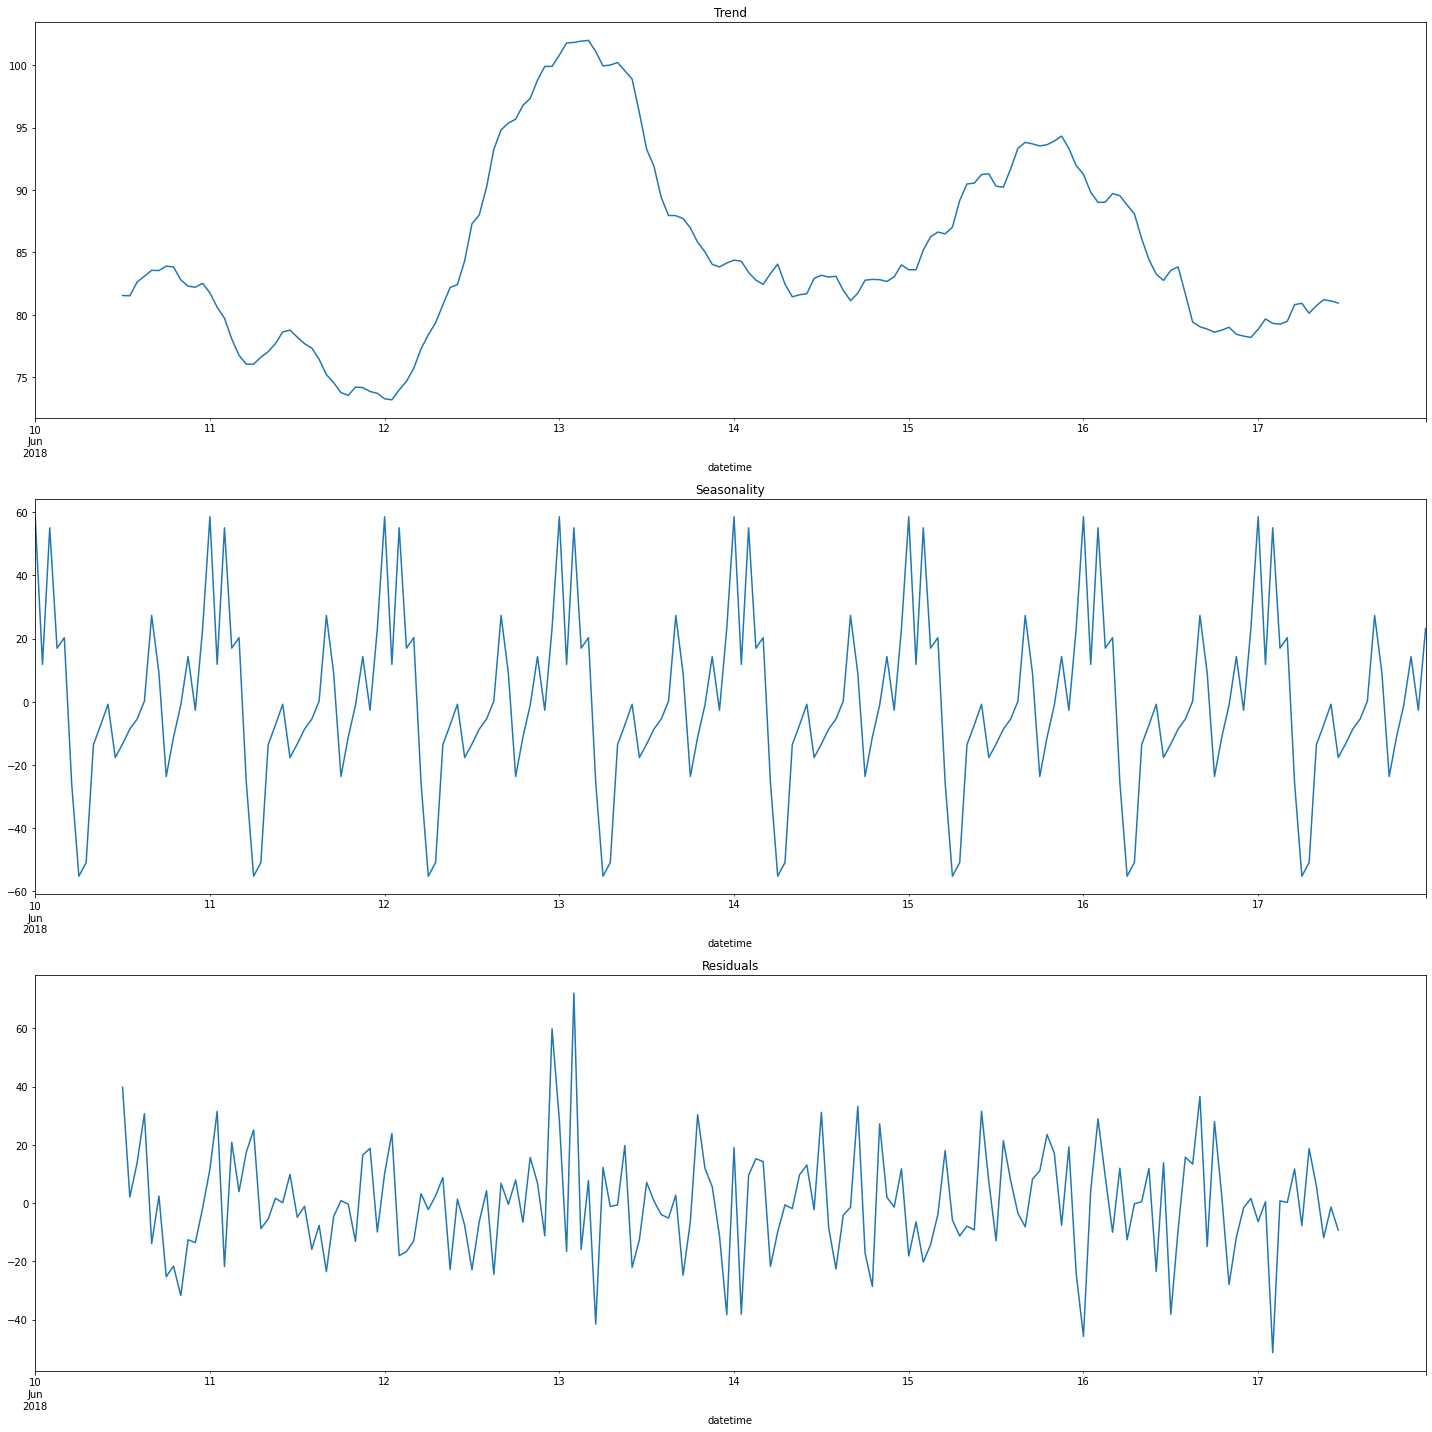

In [18]:
decomposed_data = seasonal_decompose(data_1h['2018-06-10':'2018-06-17'])

plt.figure(figsize=(20, 20))

plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

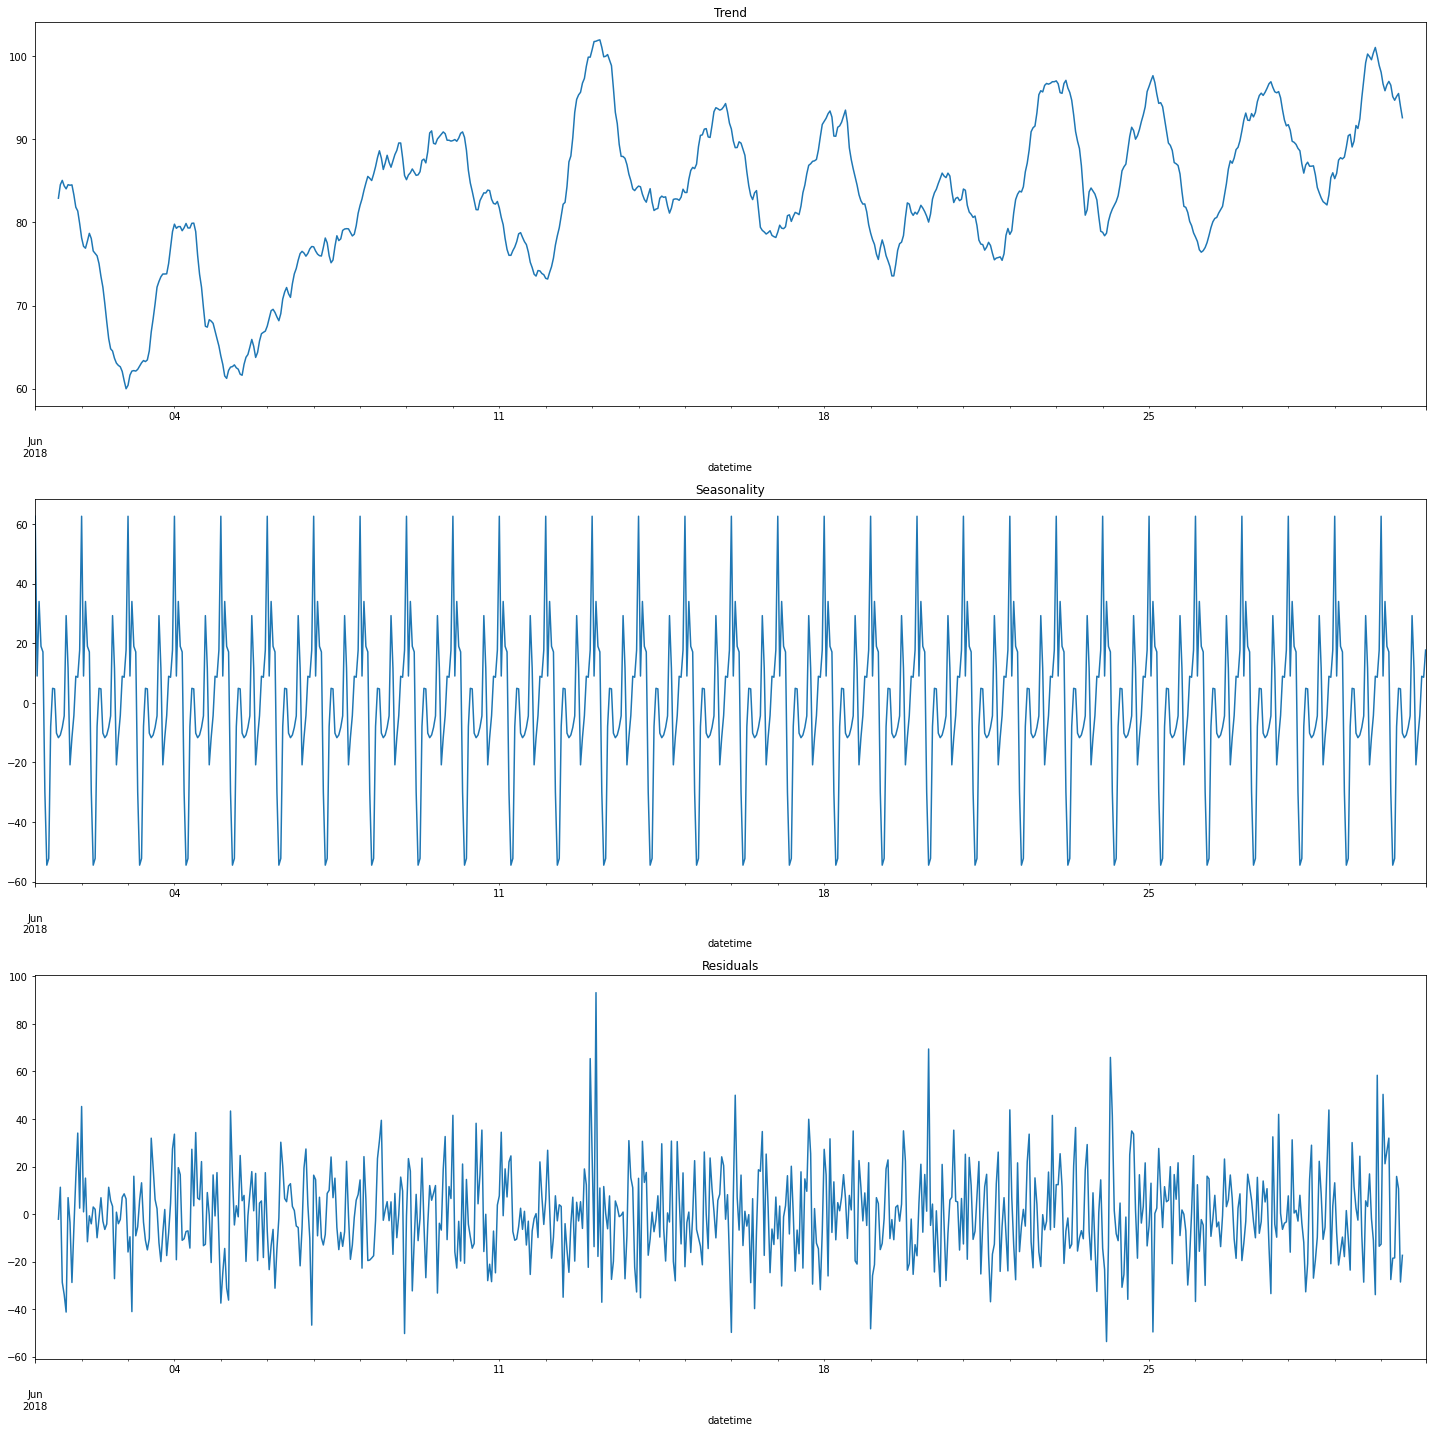

In [19]:
decomposed_data = seasonal_decompose(data_1h['2018-06'])

plt.figure(figsize=(20, 20))

plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

### Вывод

Тренд не прослеживается в рамкай одной недели, но изменения в течение недели достаточны чтобы предположить разницу спроса в зависимости от дня. Тренд за месяц достаточен чтобы увидеть увеличение спроса. Также увеличение спроса отлично прослеживается на тренде по полному временному ряду.  
Наличие меняющегося тренда означает что временной ряд нестационарен.  

Сезонные данные за неделю показывают что особым спросом пользуются ночные такси, после чего к шести утра спрос падает до минимума. Нагрузка варьируется в течение дня.

Можно предположить что "аномальные" значения увиденные ранее это, по большей части, значения на пике роста спроса.  

### Создание признаков

В качестве временных признаков использую:
- час, так как спрос меняется в течение дня;
- день недели, так как тренд показывает изменения в течение недели;
- месяц, так как спрос растет с каждым месяцем.

Для определения оптимальных lag и rolling_mean признаков использую цикл для подбора через результат RMSE линейной регрессии. При текущем объеме данных и скорости работы модели линейной регрессии подбор не займет много времени.

In [20]:
data_1h['hour'] = data_1h.index.hour
data_1h['dayofweek'] = data_1h.index.dayofweek
data_1h['month'] = data_1h.index.month

data_1h.sample()

,num_orders,hour,dayofweek,month
datetime,,,,
2018-08-10 12:00:00,112,12,4,8


In [21]:
def make_features(data, max_lag, rolling_mean_size):
    
    tmp_data = data.copy()
    
    for lag in range(1, max_lag + 1):
        tmp_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    tmp_data['rolling_mean'] = data_1h['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return tmp_data

## Обучение

In [22]:
# для фикасции результата воспользуюсь числом, полученным через генератор случайных чисел
STATE = 865154067

В данном проекте воспользуюсь моделями LinearRegression, LGBMRegressor, CatBoostRegressor и DecisionTreeRegressor.
Определю две лучшие модели для тестирования по метрике RMSE полученной путем кросс-валидации на обучающей выборке.

### Подготовка обучающей и тестовой выборок

In [23]:
%%time

model_lr = LinearRegression()

best_rmse = 9999
best_lag = 0
best_rolling_mean = 0
features_train = []
features_test = []
target_train = []
target_test = []

for max_lag in range(1, 15):
    for rolling_mean_size in range(2, 20):
        
        tmp_data = make_features(data_1h, max_lag, rolling_mean_size)
        tmp_data = tmp_data.dropna()
        
        features = tmp_data.drop('num_orders', axis = 1)
        target = tmp_data['num_orders']
        tmp_features_train, tmp_features_test, tmp_target_train, tmp_target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False, random_state=STATE)
                        
        tscv = TimeSeriesSplit()
        
# ниже дополнение

        cv_rmse = []
        index= target.reset_index().drop('num_orders', axis=1)
        
        for train_index, test_index in tscv.split(tmp_features_train):
            
            train = index.iloc[train_index]
            train_start, train_end = train.iloc[0,0], train.iloc[-1,0]
            test = index.iloc[test_index]
            test_start, test_end = test.iloc[0,0], test.iloc[-1,0]
            cv_features_train, cv_features_test = features[train_start:train_end], features[test_start:test_end]
            cv_target_train, cv_target_test = target[train_start:train_end], target[test_start:test_end]
            
            model_lr.fit(cv_features_train, cv_target_train)
            cv_predict = model_lr.predict(cv_features_test)
            
            cv_rmse.append(mean_squared_error(cv_target_test, cv_predict) ** 0.5)   
            
# конец дополнения

        if np.mean(cv_rmse) < best_rmse:
            
            best_rmse = np.mean(cv_rmse)
            features_train = tmp_features_train
            features_test = tmp_features_test
            target_train = tmp_target_train
            target_test = tmp_target_test
            best_lag = max_lag
            best_rolling_mean = rolling_mean_size
            
print('Лучшее значение max_lag -', best_lag)
print('Лучшее значение rolling_mean_size -', best_rolling_mean)
print('При RMSE -', best_rmse)

Лучшее значение max_lag - 12
Лучшее значение rolling_mean_size - 19
При RMSE - 31.430985098289067
CPU times: total: 4.11 s
Wall time: 4.12 s


### LinearRegression

In [24]:
%%time

model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

CPU times: total: 0 ns
Wall time: 2.51 ms


LinearRegression()

In [25]:
nrmse_lr = cross_val_score(model_lr, features_train, target_train, cv=TimeSeriesSplit(), scoring='neg_root_mean_squared_error')

print(nrmse_lr)
print('Значение RMSE для Линейной Регрессии:', -nrmse_lr.mean())

[-27.79596535 -28.55539792 -29.99636247 -31.37856668 -39.42863306]
Значение RMSE для Линейной Регрессии: 31.430985098289067


### LGBMRegressor

In [26]:
%%time

lgbm = LGBMRegressor(random_state=STATE)

params_lgbm = [{
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150]
}]

model_lgbm = GridSearchCV(lgbm,
                      param_grid=params_lgbm,
                      cv=TimeSeriesSplit(),
                      scoring='neg_root_mean_squared_error')

model_lgbm.fit(features_train, target_train)

CPU times: total: 30.8 s
Wall time: 1.99 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=865154067),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3],
                          'n_estimators': [50, 100, 150]}],
             scoring='neg_root_mean_squared_error')

In [27]:
print('Лучшее значение RMSE для LGBMRegressor:', -model_lgbm.best_score_)
'Оптимальные параметры модели:', model_lgbm.best_params_

Лучшее значение RMSE для LGBMRegressor: 24.959571916029454


('Оптимальные параметры модели:', {'learning_rate': 0.1, 'n_estimators': 50})

### CatBoostRegressor

In [28]:
%%time

cb = CatBoostRegressor(random_state=STATE)

params_cb = [{'depth': range(6, 10)}]

model_cb = GridSearchCV(cb,
                      param_grid=params_cb,
                      cv=TimeSeriesSplit(),
                      scoring='neg_root_mean_squared_error')

model_cb.fit(features_train, target_train)

Learning rate set to 0.03836
0:	learn: 29.1642243	total: 142ms	remaining: 2m 21s
1:	learn: 28.6662723	total: 143ms	remaining: 1m 11s
2:	learn: 28.1533172	total: 144ms	remaining: 47.8s
3:	learn: 27.7331792	total: 145ms	remaining: 36.1s
4:	learn: 27.2928460	total: 146ms	remaining: 29s
5:	learn: 26.8252701	total: 146ms	remaining: 24.3s
6:	learn: 26.3817873	total: 147ms	remaining: 20.9s
7:	learn: 26.0558624	total: 148ms	remaining: 18.4s
8:	learn: 25.6320828	total: 149ms	remaining: 16.4s
9:	learn: 25.3540507	total: 150ms	remaining: 14.8s
10:	learn: 24.9909296	total: 151ms	remaining: 13.5s
11:	learn: 24.6680074	total: 152ms	remaining: 12.5s
12:	learn: 24.4308440	total: 152ms	remaining: 11.6s
13:	learn: 24.0901686	total: 154ms	remaining: 10.8s
14:	learn: 23.8783523	total: 155ms	remaining: 10.1s
15:	learn: 23.5639480	total: 155ms	remaining: 9.55s
16:	learn: 23.2800315	total: 156ms	remaining: 9.03s
17:	learn: 23.0052880	total: 157ms	remaining: 8.56s
18:	learn: 22.7397391	total: 158ms	remaining:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000179DE153CD0>,
             param_grid=[{'depth': range(6, 10)}],
             scoring='neg_root_mean_squared_error')

In [29]:
print('Лучшее значение RMSE для CatBoostRegressor:', -model_cb.best_score_)
'Оптимальные параметры модели:', model_cb.best_params_

Лучшее значение RMSE для CatBoostRegressor: 24.610392132177637


('Оптимальные параметры модели:', {'depth': 6})

### DecisionTreeRegressor

In [30]:
%%time

dtr = DecisionTreeRegressor()

params_dtr = [{
    'max_depth': range(2, 10),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    "min_weight_fraction_leaf":[0.0, 0.1, 0.25],
    'random_state':[STATE]
}]

model_dtr = GridSearchCV(dtr,
                      param_grid=params_dtr,
                      cv=TimeSeriesSplit(),
                      scoring='neg_root_mean_squared_error')

model_dtr.fit(features_train, target_train)

CPU times: total: 3.27 s
Wall time: 3.26 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': range(2, 10),
                          'min_samples_leaf': [1, 2, 3, 4, 5],
                          'min_weight_fraction_leaf': [0.0, 0.1, 0.25],
                          'random_state': [865154067]}],
             scoring='neg_root_mean_squared_error')

In [31]:
print('Лучшее значение RMSE для DecisionTreeRegressor:', -model_dtr.best_score_)
'Оптимальные параметры модели:', model_dtr.best_params_

Лучшее значение RMSE для DecisionTreeRegressor: 30.194260021487842


('Оптимальные параметры модели:',
 {'max_depth': 6,
  'min_samples_leaf': 5,
  'min_weight_fraction_leaf': 0.0,
  'random_state': 865154067})

### Вывод

Лучшая метрика RMSE среди выбранных четырех моделей по результу кросс-валидации на обучающей выборке у моделей:
- CatBoostRegressor с RMSE = 24.61;
- LGBMRegressor c RMSE = 24.96.

Эти модели переходят в тестирование.

## Тестирование

Переобучу отобранные модели с найденными гиперпараметрами. Сравню две лучшие модели по метрике RMSE путем сравнения прогноза и тестовой выборки без кроссвалидации. Затем проверю лучшую модель на адекватность.

### CatBoostRegressor

In [32]:
%%time

model_cb = CatBoostRegressor(random_state=STATE, depth=6)

model_cb.fit(features_train, target_train)

Learning rate set to 0.050882
0:	learn: 37.7083225	total: 15.3ms	remaining: 15.3s
1:	learn: 36.7710011	total: 16.6ms	remaining: 8.28s
2:	learn: 35.9320250	total: 17.9ms	remaining: 5.96s
3:	learn: 35.2311330	total: 19.1ms	remaining: 4.77s
4:	learn: 34.4808597	total: 20.4ms	remaining: 4.05s
5:	learn: 33.8045911	total: 21.6ms	remaining: 3.57s
6:	learn: 33.1444605	total: 22.8ms	remaining: 3.23s
7:	learn: 32.5891495	total: 24ms	remaining: 2.98s
8:	learn: 32.0642208	total: 25.3ms	remaining: 2.79s
9:	learn: 31.5178072	total: 26.6ms	remaining: 2.63s
10:	learn: 31.0805984	total: 27.7ms	remaining: 2.49s
11:	learn: 30.5918242	total: 29.1ms	remaining: 2.39s
12:	learn: 30.1290765	total: 30.3ms	remaining: 2.3s
13:	learn: 29.7445776	total: 31.7ms	remaining: 2.23s
14:	learn: 29.3460493	total: 33ms	remaining: 2.17s
15:	learn: 28.9904327	total: 34.2ms	remaining: 2.11s
16:	learn: 28.7047103	total: 35.4ms	remaining: 2.05s
17:	learn: 28.4005217	total: 36.7ms	remaining: 2s
18:	learn: 28.1405279	total: 38ms	

In [33]:
%%time

cb_predict = model_cb.predict(features_test)

CPU times: total: 0 ns
Wall time: 996 µs


In [34]:
cb_RMSE = mean_squared_error(target_test, cb_predict) ** 0.5
cb_RMSE

42.159907217256006

### LGBMRegressor

In [35]:
%%time

model_lgbm = LGBMRegressor(n_estimators=50, random_state=STATE)

model_lgbm.fit(features_train, target_train)

CPU times: total: 469 ms
Wall time: 34.9 ms


LGBMRegressor(n_estimators=50, random_state=865154067)

In [36]:
%%time

lgbm_predict = model_lgbm.predict(features_test)

CPU times: total: 0 ns
Wall time: 997 µs


In [37]:
lgbm_RMSE = mean_squared_error(target_test, lgbm_predict) ** 0.5
lgbm_RMSE

42.942004244816886

### Проверка на адекватность

Модель LGBMRegressor обучается в пять раз быстрее. Модель CatBoostRegressor прогнозирует в два с половиной раза быстрее. Единственным параметром интересующим заказчика является метрика RMSE. 

Модель CatBoostRegressor показала лучший результат, 42.16 против 42.94. 

Сравню RMSE модели с RMSE константы, затем с RMSE предыдущего значения ряда.

In [38]:
# медианная константа
pred_median = np.ones(target_test.shape) * target_train.median()
print('RMSE константы:', mean_squared_error(target_test, pred_median) ** 0.5)

RMSE константы: 87.21093811714634


In [39]:
# средняя константа
pred_mean = np.ones(target_test.shape) * target_train.mean()
print('RMSE константы:', mean_squared_error(target_test, pred_mean) ** 0.5)

RMSE константы: 84.69666574934809


In [40]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE предыдущего значения ряда:', mean_squared_error(target_test, pred_previous) ** 0.5)

RMSE предыдущего значения ряда: 58.881776776551476


### Вывод

В результате теста по наименьшему значению метрики RMSE отобрана модель CatBoostRegressor. Модель прошла проверку на адекватность, показав лучший результат чем при прогнозе предыдущим значением ряда.

Визуализирую исходного ряда, прогноза лидирующих моделей и лучший из константных.

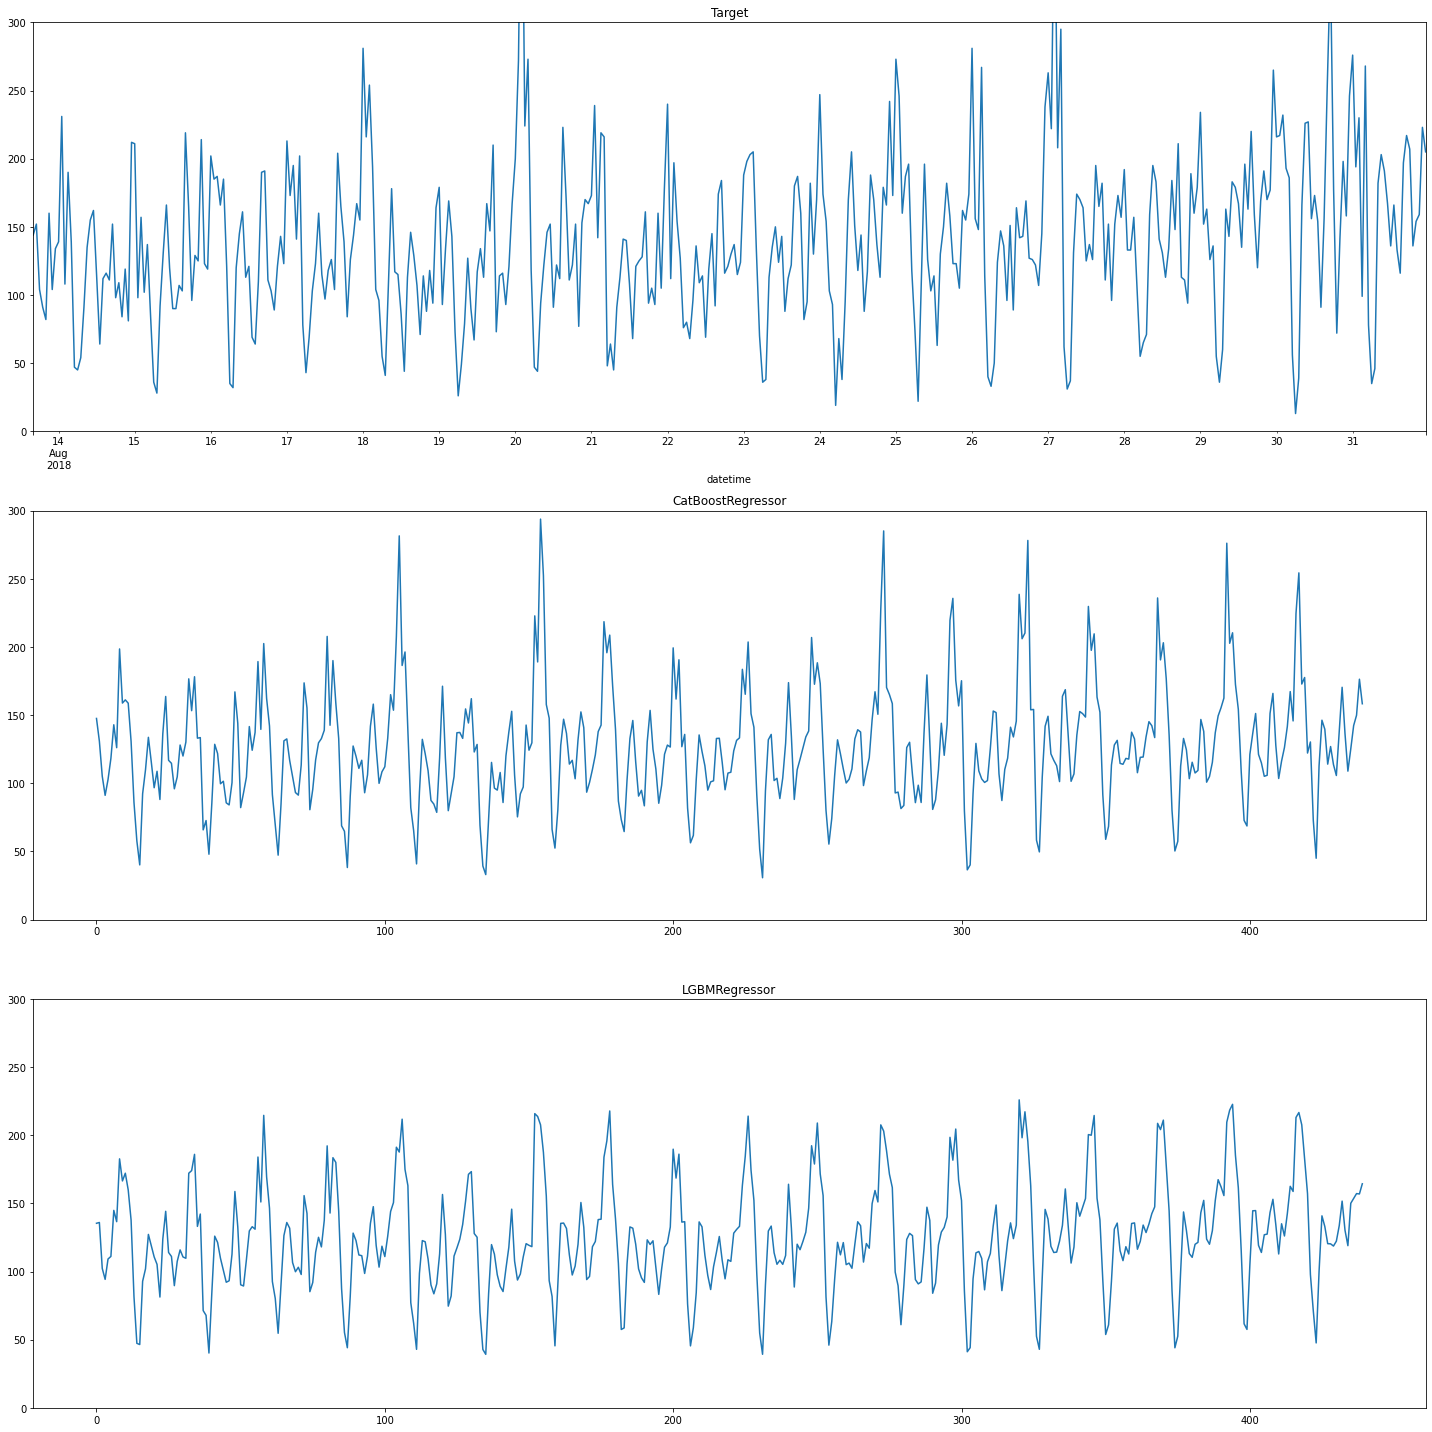

In [41]:
plt.figure(figsize=(20, 20))

plt.subplot(311)
plt.ylim((0, 300))
target_test.plot(ax=plt.gca())
plt.title('Target')

plt.subplot(312)
plt.ylim((0, 300))
pd.Series(cb_predict).plot(ax=plt.gca())
plt.title('CatBoostRegressor')

plt.subplot(313)
plt.ylim((0, 300))
pd.Series(lgbm_predict).plot(ax=plt.gca())
plt.title('LGBMRegressor')

plt.tight_layout()

Для сравнения, исходные данные и прогноз предыдущего значения ряда.

## Общий вывод

Заказчиком дано задание на построение модели способной прогнозировать объем заказов такси в аэропортах с шагом в один час. В качестве метрики качества модели выбрана RMSE. Установлен максимальный порог RMSE равный 48.

Наилучний результат показала модель CatBoostRegressor с RMSE 42.16 на тестовой выборке, что соответствует предъявленным требованиям.